In [1]:

import os
import ee
import geemap
import requests
import leafmap
import numpy as np
import pandas as pd
import geopandas as gpd
import concurrent.futures
import matplotlib.pyplot as plt
from shapely.geometry import box  
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import concurrent.futures
import ee
import requests
from tqdm import tqdm
import ast

from rasterio.errors import RasterioIOError

import rasterio

from dask import delayed, compute
from dask.diagnostics import ProgressBar
from tqdm import tqdm



In [2]:
# Replace with your actual region
region = "bihar"#lucknow_airshed
# region1 = "uttar_pradesh_v2"#lucknow_airshed


# Read metadata
metadata_path = f"/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/raw_data/sentinel_metadata/{region}_sentinel_metadata.geojson"
tif_dir = f"/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/raw_data/setinel_tiles/{region}/"
gdf = gpd.read_file(metadata_path)

# Convert CRS if needed for plotting
# gdf = gdf.to_crs("EPSG:4326")



gdf.crs   

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## visualization of tiles


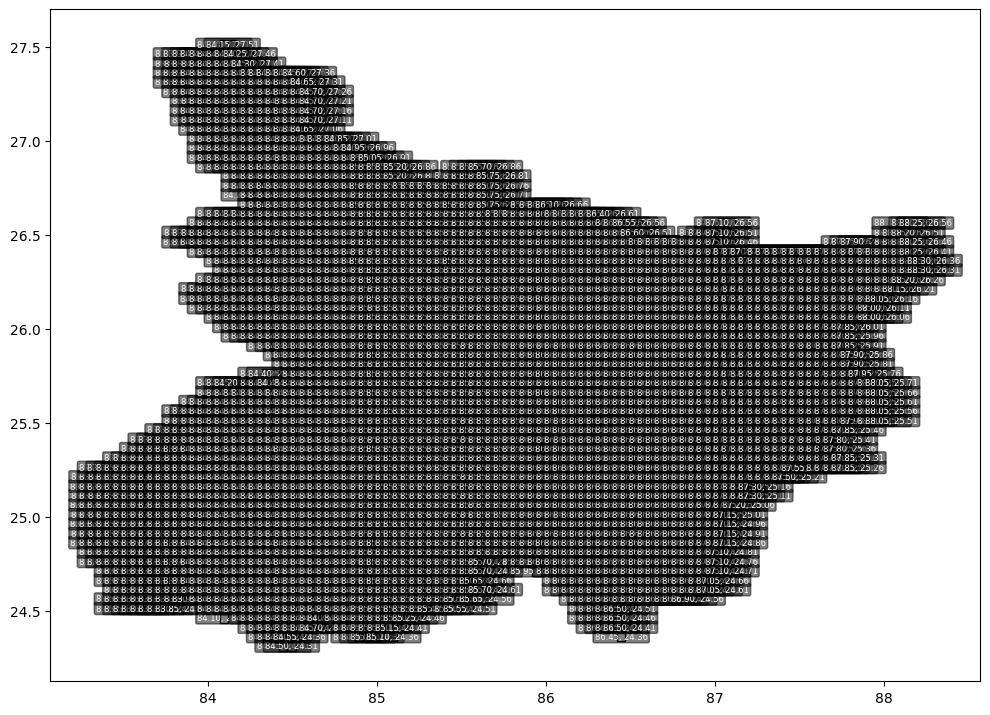

In [3]:



def parse_center(coord_str):
    try:
        return ast.literal_eval(coord_str)
    except Exception:
        return (None, None)
gdf["parsed_center"] = gdf["center_coordinates"].apply(parse_center)

# Check if area_m2 exists; if not, compute it
if 'area_m2' not in gdf.columns:
    gdf['area_m2'] = gdf.to_crs("EPSG:3857").geometry.area

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf.plot(ax=ax,edgecolor='black', facecolor='none')

for _, row in gdf.iterrows():
    lon, lat = row["parsed_center"]
    if lon and lat:
        label = f"{lon:.2f}, {lat:.2f}"
        ax.annotate(label, (lon, lat), fontsize=6, color="white",
                    ha="center", va="center", bbox=dict(facecolor="black", alpha=0.5, boxstyle="round,pad=0.2"))

## Tile Cutting

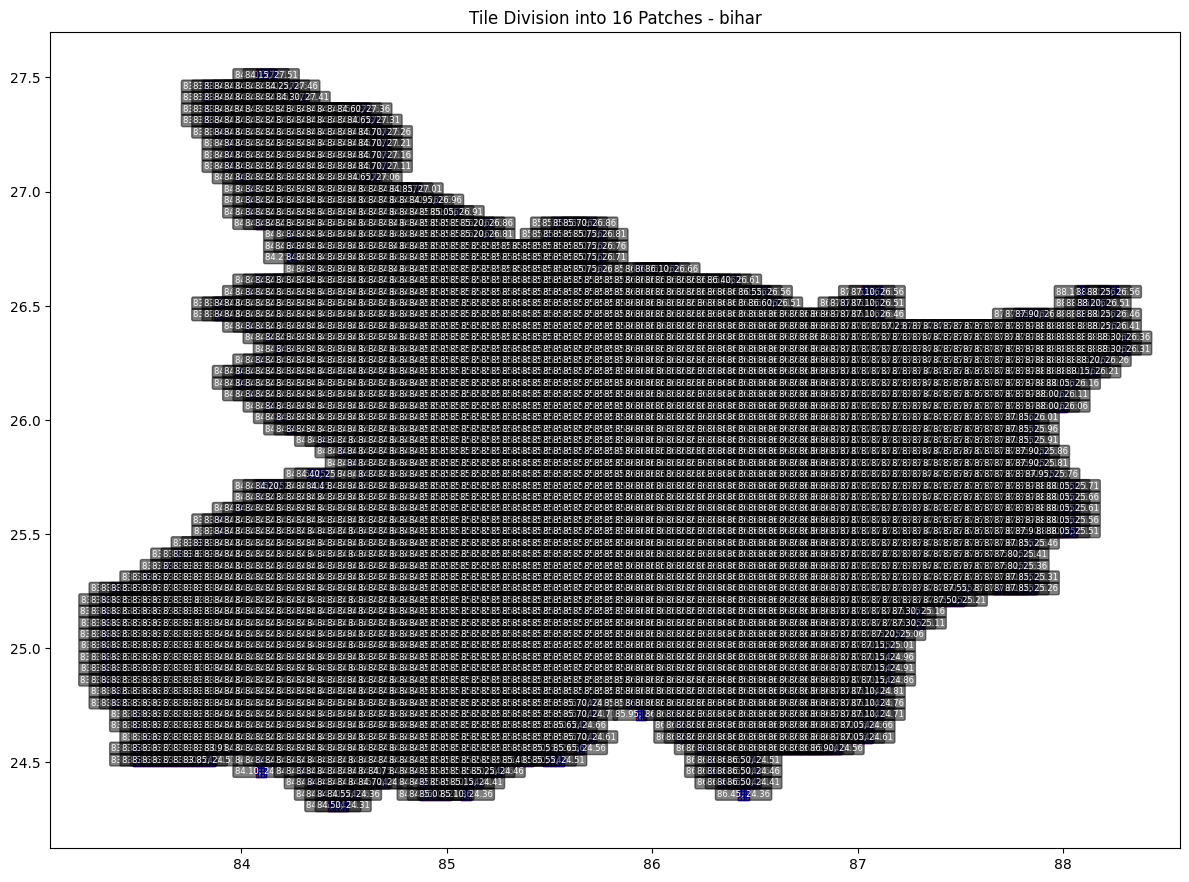

In [4]:

# Parse center coordinates from string to tuple
def parse_center(coord_str):
    try:
        return ast.literal_eval(coord_str)
    except Exception:
        return (None, None)

gdf["parsed_center"] = gdf["center_coordinates"].apply(parse_center)

# Prepare to store patches
patches = []

# Loop through each tile geometry
for _, row in gdf.iterrows():
    tile_geom = row.geometry
    minx, miny, maxx, maxy = tile_geom.bounds

    # Define split size for 8 patches (2 rows x 4 columns)
    rows, cols = 4, 4
    dx = (maxx - minx) / cols
    dy = (maxy - miny) / rows

    for i in range(rows):
        for j in range(cols):
            patch = box(minx + j*dx, miny + i*dy, minx + (j+1)*dx, miny + (i+1)*dy)
            patches.append(patch)

# Create a GeoDataFrame for patches
patches_gdf = gpd.GeoDataFrame(geometry=patches, crs="EPSG:4326")

# Plotting the original tiles and the 8 patches
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1)
patches_gdf.plot(ax=ax, edgecolor='blue', facecolor='none', linestyle='--')

# Annotate center coordinates
for _, row in gdf.iterrows():
    lon, lat = row["parsed_center"]
    if lon and lat:
        label = f"{lon:.2f}, {lat:.2f}"
        ax.annotate(label, (lon, lat), fontsize=6, color="white",
                    ha="center", va="center", bbox=dict(facecolor="black", alpha=0.5, boxstyle="round,pad=0.2"))

plt.title(f"Tile Division into 16 Patches - {region}")
plt.tight_layout()
plt.show()


## visualization of tile cutting with overlap

100%|██████████| 3608/3608 [00:14<00:00, 248.97it/s]


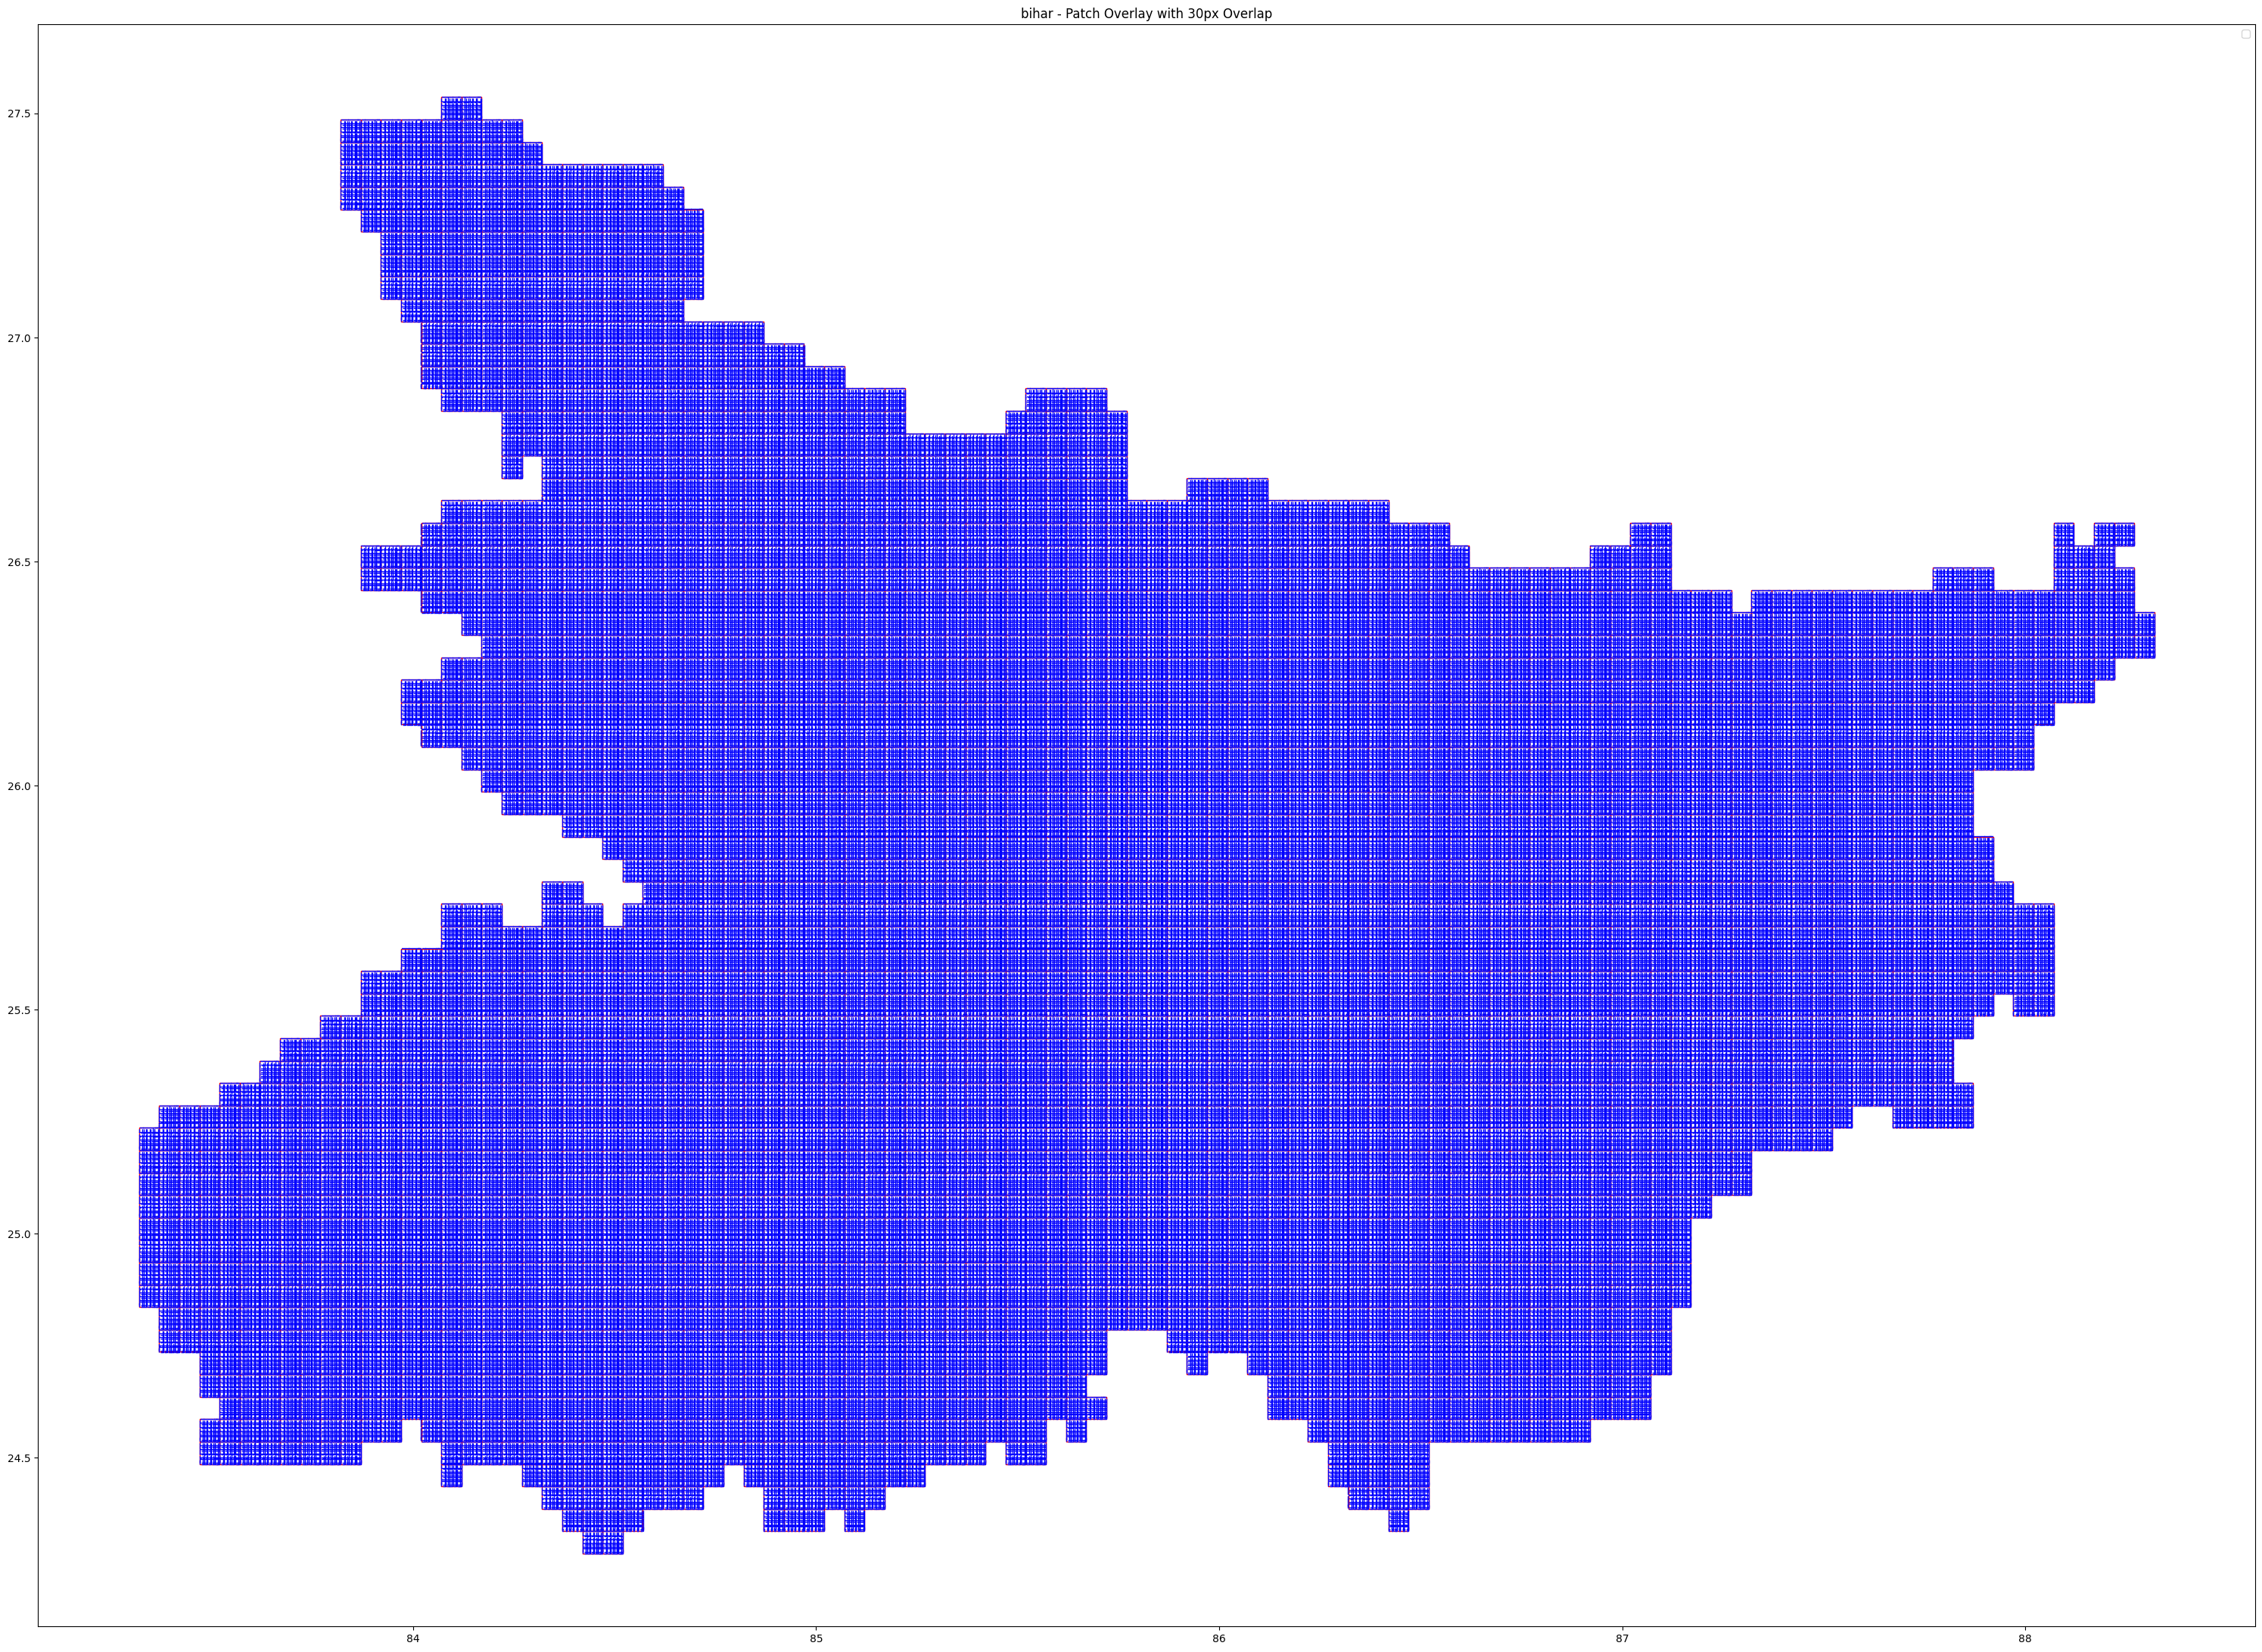

Number of files skipped due to errors: 0


In [5]:
import os
import rasterio
import geopandas as gpd
import ast
from shapely.geometry import box
from rasterio.errors import RasterioIOError
from tqdm import tqdm
import matplotlib.pyplot as plt

patch_size = 128
overlap = 30
stride = patch_size - overlap

# === Load tile metadata ===
gdf = gpd.read_file(metadata_path)
gdf = gdf.to_crs("EPSG:4326")

def parse_center(coord_str):
    try:
        return ast.literal_eval(coord_str)
    except:
        return (None, None)

gdf["parsed_center"] = gdf["center_coordinates"].apply(parse_center)

# === Generate patch polygons ===
all_patches = []
skipped_files_count = 0  # Counter for skipped files

for tif_name in tqdm(os.listdir(tif_dir)):
    if not tif_name.endswith(".tif"):
        continue

    tif_path = os.path.join(tif_dir, tif_name)

    try:
        with rasterio.open(tif_path) as src:
            width, height = src.width, src.height
            transform = src.transform

            # Ensure complete coverage with overlap
            x_centers = []
            x = 0
            while x + patch_size <= width:
                x_centers.append(x + patch_size // 2)
                x += stride
            if x_centers[-1] + patch_size // 2 < width:
                x_centers.append(width - patch_size // 2)

            y_centers = []
            y = 0
            while y + patch_size <= height:
                y_centers.append(y + patch_size // 2)
                y += stride
            if y_centers[-1] + patch_size // 2 < height:
                y_centers.append(height - patch_size // 2)

            for y in y_centers:
                for x in x_centers:
                    x0 = x - patch_size // 2
                    y0 = y - patch_size // 2
                    x1 = x0 + patch_size
                    y1 = y0 + patch_size

                    # Convert pixel coordinates to lat/lon bounds
                    lon_min, lat_max = rasterio.transform.xy(transform, y0, x0, offset='ul')
                    lon_max, lat_min = rasterio.transform.xy(transform, y1, x1, offset='lr')

                    poly = box(lon_min, lat_min, lon_max, lat_max)
                    all_patches.append(poly)

    except RasterioIOError as e:
        # print(f"⚠️ Skipping unsupported file: {tif_path} — {e}")
        skipped_files_count += 1  # Increment counter for skipped files
        continue
    except Exception as e:
        # print(f"⚠️ Unexpected error with file {tif_path}: {e}")
        skipped_files_count += 1  # Increment counter for skipped files
        continue

# === Create GeoDataFrame of patches ===
patches_gdf = gpd.GeoDataFrame(geometry=all_patches, crs="EPSG:4326")

# === Plot patches over original tiles ===
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1, label="Original Tiles")
patches_gdf.plot(ax=ax, edgecolor='blue', facecolor='none', linestyle='--', label="Patches")

# Annotate center coordinates
# for _, row in gdf.iterrows():
#     lon, lat = row["parsed_center"]
#     if lon and lat:
#         label = f"{lon:.2f}, {lat:.2f}"
#         ax.annotate(label, (lon, lat), fontsize=6, color="white",
#                     ha="center", va="center", bbox=dict(facecolor="black", alpha=0.5, boxstyle="round,pad=0.2"))

plt.title(f"{region} - Patch Overlay with {overlap}px Overlap")
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig(f"{region}_patch_overlay.png", dpi=300)

# Print the count of skipped files
print(f"Number of files skipped due to errors: {skipped_files_count}")


In [88]:
# === Visualization in Leafmap ===
m = leafmap.Map()
m.add_basemap("HYBRID")

# Add original tiles (red outlines)
m.add_gdf(gdf, layer_name="Original Tiles", style={"color": "red", "weight": 2, "fillOpacity": 0})

# Add patch overlays (blue outlines)
m.add_gdf(patches_gdf, layer_name="Patches", style={"color": "blue", "weight": 1, "dashArray": "5,5", "fillOpacity": 0},zoom_to_layer=True)

# Zoom to data
# m.zoom_to_gdf(patches_gdf)

# m

In [6]:
patch_size = 128
overlap = 30
stride = patch_size - overlap

# === Load tile metadata ===
gdf = gpd.read_file(metadata_path)
gdf = gdf.to_crs("EPSG:4326")

def parse_center(coord_str):
    try:
        return ast.literal_eval(coord_str)
    except:
        return (None, None)

gdf["parsed_center"] = gdf["center_coordinates"].apply(parse_center)

# === Patch Generation & Visualization ===
patch_records = []
tif_files = sorted([f for f in os.listdir(tif_dir) if f.endswith(".tif")])  

for tif_name in tqdm(tif_files):
    tif_path = os.path.join(tif_dir, tif_name)

    with rasterio.open(tif_path) as src:
        width, height = src.width, src.height
        transform = src.transform

        x_centers = []
        x = 0
        while x + patch_size <= width:
            x_centers.append(x + patch_size // 2)
            x += stride
        if x_centers[-1] + patch_size // 2 < width:
            x_centers.append(width - patch_size // 2)

        y_centers = []
        y = 0
        while y + patch_size <= height:
            y_centers.append(y + patch_size // 2)
            y += stride
        if y_centers[-1] + patch_size // 2 < height:
            y_centers.append(height - patch_size // 2)

        # # === Read RGB bands ===
        # img = src.read([1, 2, 3])
        # img = np.transpose(img, (1, 2, 0))
        # img = (img - img.min()) / (img.max() - img.min())

        # === Plot Full Tile with Patches ===
        # fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        # ax.imshow(img)
        # ax.set_title(f"All Patches over Tile: {tif_name}")

        for y in y_centers:
            for x in x_centers:
                x0 = x - patch_size // 2
                y0 = y - patch_size // 2
                x1 = x0 + patch_size
                y1 = y0 + patch_size

                # Bounding box in lon/lat
                # Bounding box in lon/lat
                lon_min, lat_max = rasterio.transform.xy(transform, y0, x0, offset='ul')
                lon_max, lat_min = rasterio.transform.xy(transform, y1, x1, offset='lr')
                lon_center = (lon_min + lon_max) / 2
                lat_center = (lat_min + lat_max) / 2

                poly = box(lon_min, lat_min, lon_max, lat_max)

                patch_records.append({
                    "tile_name": tif_name,
                    "lon_center": lon_center,
                    "lat_center": lat_center,
                    "geometry": poly
                })

                # # Draw patch box
                # ax.add_patch(plt.Rectangle((x0, y0), patch_size, patch_size,
                #                         edgecolor='cyan', facecolor='none', linewidth=0.8))

                # # Draw center coordinates on the image
                # text_str = f"{lat_center:.4f}, {lon_center:.4f}"
                # ax.text(x, y, text_str, fontsize=6, color='yellow',
                #         ha='center', va='center', bbox=dict(boxstyle="round,pad=0.1", fc="black", alpha=0.5))

# # === Save Patch Metadata ===
patches_gdf = gpd.GeoDataFrame(patch_records, crs="EPSG:4326")
patches_gdf.to_file(f"/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/{region}_metadata.geojson", driver="GeoJSON")
# patches_gdf[["tile_name", "lon_center", "lat_center"]].to_csv(f"{region}_patch_centers.csv", index=False)

print(f"Saved {len(patches_gdf)} patches.")


100%|██████████| 3608/3608 [00:14<00:00, 246.91it/s]


Saved 129888 patches.


In [7]:
potential_image_shape = gpd.read_file(f"/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/{region}_metadata.geojson")
print(potential_image_shape.head(2))

                  tile_name  lon_center  lat_center  \
0  Tile_83.3203_24.8361.tif   83.325974   24.880414   
1  Tile_83.3203_24.8361.tif   83.334778   24.880414   

                                            geometry  
0  POLYGON ((83.33177 24.87462, 83.33177 24.88621...  
1  POLYGON ((83.34057 24.87462, 83.34057 24.88621...  


In [8]:
# potential_image_shape=gpd.read_file(f"{region}_patch_centers.geojson")
print("Original CRS:", potential_image_shape.crs)
potential_image_shape = potential_image_shape.to_crs("EPSG:3857")
print("Updated CRS:", potential_image_shape.crs)
# #plot that 
# fig,ax=plt.subplots(1,1,figsize=(4,4))
# potential_image_shape.plot(ax=ax,edgecolor='red',facecolor='none')
# m = leafmap.Map()
# m.add_basemap("HYBRID")
# m.add_gdf(potential_image_shape, layer_name="Patch Geometry",zoom_to_layer=True)
# m


Original CRS: EPSG:4326
Updated CRS: EPSG:3857


## save patch 

In [9]:
from joblib import Parallel, delayed
import os
import ast
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.errors import RasterioIOError
from shapely.geometry import box
from tqdm import tqdm
from PIL import Image


# Setup
patch_save_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel"
save_dirs = {
    "rgb": f"{patch_save_path}/{region}/rgb",
    # "color_infrared": f"{patch_save_path}/{region}/color_infrared",
    # "geology": f"{patch_save_path}/{region}/geology",
    # "agriculture": f"{patch_save_path}/{region}/agriculture",
    # "short_wave": f"{patch_save_path}/{region}/short_wave"
}
for path in save_dirs.values():
    os.makedirs(path, exist_ok=True)

# Load metadata
gdf = gpd.read_file(metadata_path).to_crs("EPSG:4326")
gdf["parsed_center"] = gdf["center_coordinates"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else (None, None))

# Normalization function
def norm(band):
    return ((band - band.min()) / (band.max() - band.min() + 1e-5) * 255).astype(np.uint8)

# === Parallelized Tile Processor ===
def process_tile(tif_name):
    tif_path = os.path.join(tif_dir, tif_name)
    local_records = []

    try:
        with rasterio.open(tif_path) as src:
            width, height = src.width, src.height
            transform = src.transform

            x_centers = [x + patch_size // 2 for x in range(0, width - patch_size + 1, stride)]
            if x_centers and x_centers[-1] + patch_size // 2 < width:
                x_centers.append(width - patch_size // 2)

            y_centers = [y + patch_size // 2 for y in range(0, height - patch_size + 1, stride)]
            if y_centers and y_centers[-1] + patch_size // 2 < height:
                y_centers.append(height - patch_size // 2)

            for yc in y_centers:
                for xc in x_centers:
                    x0, y0 = xc - patch_size // 2, yc - patch_size // 2
                    x1, y1 = x0 + patch_size, y0 + patch_size

                    lon_min, lat_max = rasterio.transform.xy(transform, y0, x0, offset='ul')
                    lon_max, lat_min = rasterio.transform.xy(transform, y1, x1, offset='lr')
                    lon_center = round((lon_min + lon_max) / 2, 4)
                    lat_center = round((lat_min + lat_max) / 2, 4)

                    poly = box(lon_min, lat_min, lon_max, lat_max)
                    local_records.append({
                        "tile_name": tif_name,
                        "lon_center": lon_center,
                        "lat_center": lat_center,
                        "geometry": poly
                    })

                    try:
                        red = src.read(1)[y0:y1, x0:x1]
                        green = src.read(2)[y0:y1, x0:x1]
                        blue = src.read(3)[y0:y1, x0:x1]
                        # nir = src.read(4)[y0:y1, x0:x1]
                        # swir11 = src.read(5)[y0:y1, x0:x1]
                        # swir12 = src.read(6)[y0:y1, x0:x1]
                    except:
                        continue

                    red_norm = norm(red)
                    green_norm = norm(green)
                    blue_norm = norm(blue)
                    # nir_norm = norm(nir)
                    # swir11_norm = norm(swir11)
                    # swir12_norm = norm(swir12)

                    composites = {
                        "rgb": np.dstack((red_norm, green_norm, blue_norm))
                        # "color_infrared": np.dstack((nir_norm, red_norm, green_norm)),
                        # "geology": np.dstack((swir12_norm, swir11_norm, blue_norm)),
                        # "agriculture": np.dstack((swir11_norm, nir_norm, blue_norm)),
                        # "short_wave": np.dstack((swir12_norm, nir_norm, red_norm))
                    }

                    patch_id = f"{lat_center:.4f}_{lon_center:.4f}"
                    for name, patch_img in composites.items():
                        save_path = os.path.join(save_dirs[name], f"{patch_id}.png")
                        # save the images in rgb format
                        Image.fromarray(patch_img).convert("RGB").save(save_path)


    except RasterioIOError:
        print(f"Skipped unsupported file: {tif_path}")

    return local_records

# Parallel execution
tif_files = sorted([f for f in os.listdir(tif_dir) if f.endswith(".tif")])
all_records = Parallel(n_jobs=42)(delayed(process_tile)(tif_name) for tif_name in tqdm(tif_files, desc="Processing Sentinel Tiles"))
patch_records = [record for sublist in all_records for record in sublist]  # Flatten


Processing Sentinel Tiles: 100%|██████████| 3608/3608 [00:29<00:00, 123.57it/s]


## extra code 

## Label Processing

In [10]:
# statename="bangladesh_v4"
statename="india_v5"
label_path=f"/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/after_hand_validation_data/{statename}/final/{statename}.geojson"
gdf_labels = gpd.read_file(label_path).drop("style", errors="ignore", axis=1)

color_mapping = {"CFCBK": "red", "FCBK": "orange", "Zigzag": "green"}
gdf_labels["style"] = gdf_labels["class_name"].apply(lambda x: {"color": color_mapping[x]})

In [11]:
gdf_labels_webm=gdf_labels.to_crs(potential_image_shape.crs)
gdf_labels_webm.reset_index(inplace=True, drop=True)
print(gdf_labels_webm.crs)
print("Number of labels:", len(gdf_labels_webm))

gdf_labels_webm.head(2)

EPSG:3857
Number of labels: 42982


class_name  confidence    max_lon    min_lon    max_lat    min_lat  \
0     Zigzag    0.875191  76.814466  76.812802  29.027524  29.026580   
1     Zigzag    0.862482  77.411585  77.409582  27.903229  27.902481   

   center_lat  center_lon  width_of_box  height_of_box  ...   y  yolo_label  \
0   29.027052   76.813634    162.093489     104.604466  ... NaN        None   
1   27.902855   77.410584    197.219040      82.939175  ... NaN        None   

   label_index  Name  Description  image_center_lat  image_center_lon  \
0          NaN  None         None               NaN               NaN   
1          NaN  None         None               NaN               NaN   

   view_index                                           geometry  \
0         NaN  POLYGON ((8550946.461 3379029.508, 8550947.241...   
1         NaN  POLYGON ((8617195.251 3236777.516, 8617195.696...   

                style  
0  {'color': 'green'}  
1  {'color': 'green'}  

[2 rows x 36 columns]

In [95]:
# print(labels_gdf["geometry"][0])
#change the crs

In [12]:
images_with_label=gpd.sjoin(potential_image_shape,gdf_labels_webm,predicate="contains")
images_with_label['geometry_right'] = images_with_label['index_right'].apply(lambda x: gdf_labels_webm.loc[x, 'geometry'])
print(f"Number of labels to write: {len(images_with_label)}")
print(f"Number of unique images: {len(images_with_label.drop_duplicates(subset='geometry'))}")
print(f"Number of unique labels: {len(images_with_label.drop_duplicates(subset='geometry_right'))}")

Number of labels to write: 12915
Number of unique images: 9835
Number of unique labels: 7430


In [97]:
images_with_label.head(2)

tile_name  lon_center  lat_center  \
12  Tile_80.6500_26.6000.tif   80.655732   26.626649   
18  Tile_80.6500_26.6000.tif   80.655732   26.617845   

                                             geometry  index_right class_name  \
12  POLYGON ((8979200 3076181.9, 8979200 3077624.9...        18433     Zigzag   
18  POLYGON ((8979200 3075085.734, 8979200 3076528...        18433     Zigzag   

    confidence    max_lon    min_lon    max_lat  ...   y  yolo_label  \
12    0.943757  80.652701  80.651573  26.623088  ... NaN        None   
18    0.943757  80.652701  80.651573  26.623088  ... NaN        None   

    label_index  Name  Description  image_center_lat  image_center_lon  \
12          NaN  None         None             26.62             80.65   
18          NaN  None         None             26.62             80.65   

    view_index               style  \
12         NaN  {'color': 'green'}   
18         NaN  {'color': 'green'}   

                                       geometry_right  
12  POLYGON ((8978146.807226 3076310.0568897505, 8...  
18  POLYGON ((8978146.807226 3076310.0568897505, 8...  

[2 rows x 41 columns]

In [13]:
gdf_labels_webm["geometry"]
class_mapping = {"CFCBK": 0, "FCBK": 1, "Zigzag": 2}
def get_yolo_label(x):
    image_polygon=x['geometry']
    label_polygon=x['geometry_right']
    min_x, min_y, max_x, max_y = image_polygon.bounds
    coords = np.array(label_polygon.__geo_interface__['coordinates'][0][:-1])  
    coords[:, 0] = (coords[:, 0] - min_x) / (max_x - min_x)
    coords[:, 1] = 1 - (coords[:, 1] - min_y) / (max_y - min_y)
    coords = coords.ravel()
    assert len(coords) == 8
    class_id = class_mapping[x['class_name']]
    label = np.zeros(9) * np.nan
    label[0] = class_mapping.get(x['class_name'],-1)
    label[1:] = coords
    return label

In [14]:
images_with_label['yolo_label_s'] = images_with_label.apply(get_yolo_label, axis=1)
images_with_label.head(2)

tile_name  lon_center  lat_center  \
223  Tile_83.3203_25.1361.tif   83.334778   25.171558   
229  Tile_83.3203_25.1361.tif   83.334778   25.162754   

                                              geometry  index_right  \
223  POLYGON ((9277430 2896118.734, 9277430 2897544...        24702   
229  POLYGON ((9277430 2895035.998, 9277430 2896461...        24702   

    class_name  confidence    max_lon    min_lon  max_lat  ...  yolo_label  \
223       FCBK    0.932337  83.333408  83.332845  25.1679  ...        None   
229       FCBK    0.932337  83.333408  83.332845  25.1679  ...        None   

     label_index  Name  Description  image_center_lat  image_center_lon  \
223          NaN  None         None             25.17             83.33   
229          NaN  None         None             25.17             83.33   

     view_index                style  \
223      8184.0  {'color': 'orange'}   
229      8184.0  {'color': 'orange'}   

                                        geometry_right  \
223  POLYGON ((9276569.871754795 2896255.787395476,...   
229  POLYGON ((9276569.871754795 2896255.787395476,...   

                                          yolo_label_s  
223  [1.0, 0.33323391844646016, 0.9038461329184205,...  
229  [1.0, 0.33323391844646016, 0.14415794167617058...  

[2 rows x 42 columns]

In [15]:
print("Total geometries:", len(images_with_label['geometry_right']))
geometry_gdf = gpd.GeoDataFrame(geometry=images_with_label['geometry_right'],crs="EPSG:3857" )
geometry_gdf = geometry_gdf.to_crs("EPSG:4326")
m = leafmap.Map()
m.add_basemap("HYBRID")
m.add_gdf(geometry_gdf, layer_name="Detected Bounding Boxes",zoom_to_layer=True)    
# m


Total geometries: 12915


In [16]:
def has_negative(label):
    return np.any(label < 0)

# Filter rows where any value in label is negative (excluding class_id if needed)
negatives = images_with_label[images_with_label['yolo_label_s'].apply(has_negative)]

print(f"Found {len(negatives)} entries with negative values in YOLO-OBB labels.")
if len(negatives) > 0:
    print(negatives[['lat_center', 'lon_center', 'yolo_label']].head())


Found 0 entries with negative values in YOLO-OBB labels.


In [17]:
# # Group by lon_center and lat_center
# from pathlib import Path
# label_dir = f"/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel_2/{region}/labels"

# images_with_label['lon_center:.4f'] = images_with_label['lon_center'].round(4)
# images_with_label['lat_center:.4f'] = images_with_label['lat_center'].round(4)
# grouped = images_with_label.groupby(['lon_center:.4f', 'lat_center:.4f'])
# grouped_counts = grouped.size().reset_index(name='count')
# print(grouped_counts)


# grouped_counts["file_name"] = grouped_counts.apply(
#     lambda row: f"{row['lon_center:.4f']:.4f}_{row['lat_center:.4f']:.4f}.txt", axis=1
# )

# expected_files = set(grouped_counts["file_name"].tolist())
# existing_files = set(os.listdir(label_dir))
# matching_files = expected_files & existing_files
# missing_files = expected_files - existing_files
# extra_files = existing_files - expected_files

# print(f"✅ Matching label files: {len(matching_files)}")
# print(f"❌ Missing label files: {len(missing_files)}")
# print(f"⚠️ Extra label files not in grouped data: {len(extra_files)}")

# # Optional: list a few examples
# print("Examples of missing:", list(missing_files)[:5])
# print("Examples of extra:", list(extra_files)[:5])


In [18]:
from os.path import join
import glob

save_dir= f"/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/{region}"

label_dir_path = join(save_dir, "labels")
print(f"Creating directory: {label_dir_path}")
os.makedirs(label_dir_path, exist_ok=True)
grouped = images_with_label.groupby(['lat_center', 'lon_center'])
for (lat_center, lon_center), group in grouped:
    labels = np.vstack(group['yolo_label_s'].values)  # stack all label rows
    save_path = join(label_dir_path, f"{lat_center:.4f}_{lon_center:.4f}.txt")
    np.savetxt(save_path, labels, fmt="%d %f %f %f %f %f %f %f %f")

print(f"Saved {len(grouped)} YOLO-OBB label files to: {label_dir_path}")

label_files = glob.glob(os.path.join(label_dir_path, "*.txt"))

bad_files = []
for file in label_files:
    data = np.loadtxt(file, ndmin=2)  
    if np.any(data[:, 1:] < 0): 
        bad_files.append(file)

print(f"Found {len(bad_files)} files with negative label coordinates.")
if bad_files:
    print("Examples:", bad_files[:5])


Creating directory: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/bihar/labels
Saved 9835 YOLO-OBB label files to: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/bihar/labels
Found 0 files with negative label coordinates.


In [19]:
# potential_image_shape=gpd.read_file(f"{region}_patch_centers.geojson")
# print("Original CRS:", potential_image_shape.crs)
# potential_image_shape = potential_image_shape.to_crs("EPSG:3857")
# print("Updated CRS:", potential_image_shape.crs)

# m = leafmap.Map()
# m.add_basemap("HYBRID")
# # m.add_gdf(potential_image_shape, layer_name="Patch Geometry",zoom_to_layer=True)
# m.add_gdf(
#     potential_image_shape,
#     layer_name="Patch Geometry",
#     zoom_to_layer=False,
#     style={
#         "color": "black",       # border color
#         "fillColor": "transparent",  # transparent fill
#         "weight": 1.5,          # border thickness
#         "fillOpacity": 0        # ensure fill is invisible
#     }
# )
# # m.add_gdf(geometry_gdf, layer_name="Detected Bounding Boxes",zoom_to_layer=True)
# m.add_gdf(
#     geometry_gdf,
#     layer_name="Detected Bounding Boxes",
#     style={
#         "color": "red",       # border color
#         "fillColor": "transparent",  # transparent fill
#         "weight": 2.5,          # border thickness
#         "fillOpacity": 0.5        # ensure fill is invisible
#     },
#     zoom_to_layer=True,
#     legend_title="Brick Kiln Class",
#     tooltip="Detected Bounding Box"  # added tooltip for better interactivity
# )
# m

In [20]:
import os

label_dir = f"/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/{region}/labels"
image_dir = f"/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/{region}/rgb"

# Get filenames without extensions
label_files = set(os.path.splitext(f)[0] for f in os.listdir(label_dir) if f.endswith(".txt"))
image_files = set(os.path.splitext(f)[0] for f in os.listdir(image_dir) if f.endswith(".png"))

# Compute matches and mismatches
matched = label_files & image_files
unmatched_labels = label_files - image_files
unmatched_images = image_files - label_files

# Print counts
print(f"✅ Matched files: {len(matched)}")
print(f"❌ Unmatched labels (no corresponding image): {len(unmatched_labels)}")
print(f"❌ Unmatched images (no corresponding label): {len(unmatched_images)}")

# Optionally, print mismatched file names
# print("Unmatched label files:", unmatched_labels)
# print("Unmatched image files:", unmatched_images)


✅ Matched files: 9835
❌ Unmatched labels (no corresponding image): 0
❌ Unmatched images (no corresponding label): 120053


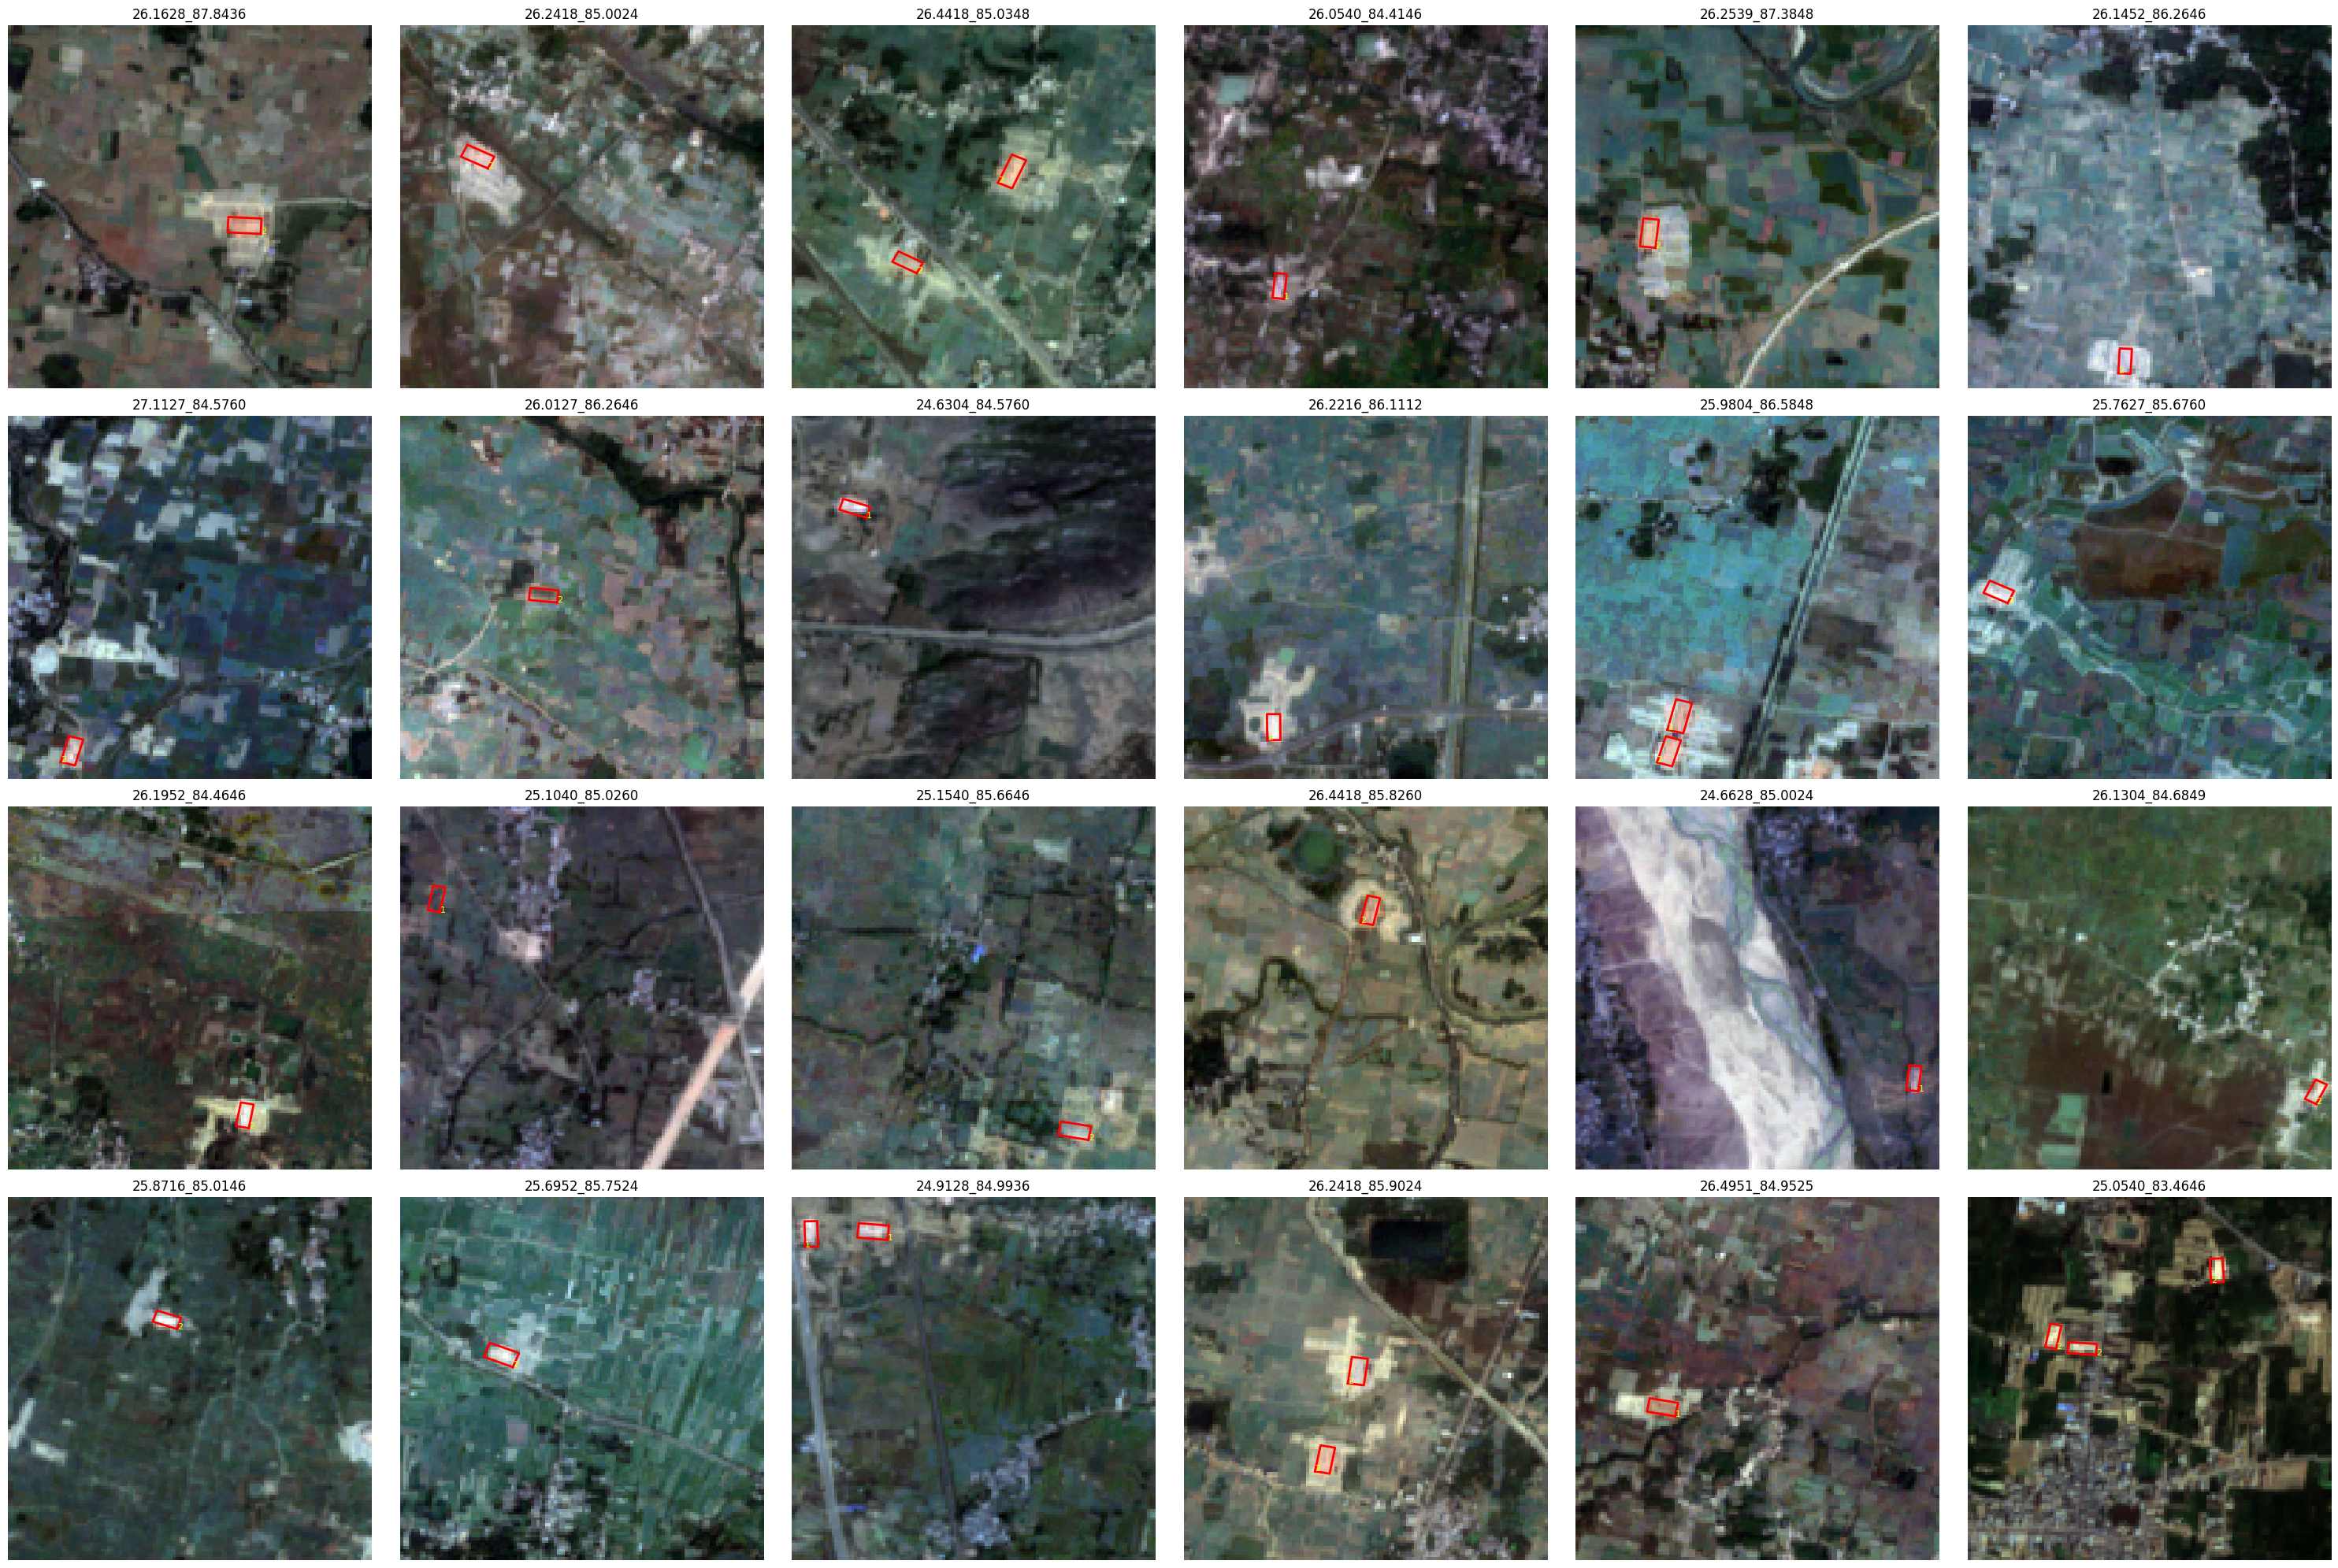

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from os.path import join, splitext, basename

# CONFIGURATION
label_dir = f"/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/{region}/labels"
image_dir = f"/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/{region}/rgb"
image_size = 128  # Sentinel image size in pixels
NUM_IMAGES_TO_SHOW = 24

# LOAD LABEL FILES
label_files = glob(join(label_dir, "*.txt"))
selected_label_files = np.random.choice(label_files, size=min(NUM_IMAGES_TO_SHOW, len(label_files)), replace=False)

# PLOT MULTIPLE IMAGES
cols = 6
rows = int(np.ceil(len(selected_label_files) / cols))
plt.figure(figsize=(cols * 5, rows * 5))

for i, label_file in enumerate(selected_label_files, start=1):
    base = splitext(basename(label_file))[0]
    image_file = join(image_dir, base + ".png")

    if not os.path.exists(image_file):
        print(f"🚫 Image not found: {image_file}")
        continue

    try:
        # Load image and labels
        image = Image.open(image_file).convert("RGB")
        image_np = np.array(image)
        labels = np.loadtxt(label_file, ndmin=2)

        # Plot
        plt.subplot(rows, cols, i)
        plt.imshow(image_np)
        plt.axis("off")
        plt.title(f"{base}", fontsize=12)

        for label in labels:
            class_id = int(label[0])
            coords = label[1:] * image_size
            coords = coords.reshape(-1, 2)
            coords = np.vstack([coords, coords[0]])  # close polygon
            plt.plot(coords[:, 0], coords[:, 1], 'r-', linewidth=2)
            plt.text(coords[0, 0], coords[0, 1], f"{class_id}", color="yellow", fontsize=8)

    except Exception as e:
        print(f"⚠️ Error with file {label_file}: {e}")

plt.tight_layout()
plt.show()
